# Household Test

In [3]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [4]:
model = BabyMAKROModelClass(name='Extended')

In [5]:
par = model.par
ss = model.ss
sol = model.sol

# Labor supply

In [6]:
from steady_state import households_search_ss
ss.m_s = par.m_s_ss # required input

In [7]:
households_search_ss(par, ss)

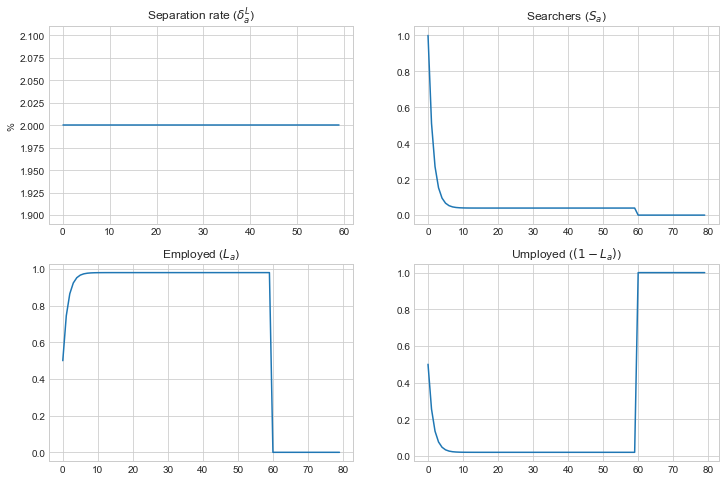

In [13]:
fig = plt.figure(figsize=(2*6,2*6/1.5))

ax = fig.add_subplot(2,2,1)
ax.plot(par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('Separation rate ($\delta^L_a$)');

ax = fig.add_subplot(2,2,2)
ax.plot(ss.S_a)
ax.set_title('Searchers ($S_a$)')

ax = fig.add_subplot(2,2,3)
ax.plot(ss.L_a)
ax.set_title('Employed ($L_a$)')

ax = fig.add_subplot(2,2,4)
ax.plot(1-ss.L_a)
ax.set_title('Umployed ($(1-L_a)$)');

In [14]:
from steady_state import find_household_consumption_ss, household_ss

**Required inputs:**

In [15]:
ss.W = par.W_ss
ss.pi_hh = par.pi_hh_ss
ss.P_C = 1.0
ss.tau = 0.42
ss.real_r_hh = (1+par.r_hh)/(1+ss.pi_hh)-1

**Solve:**

In [17]:
find_household_consumption_ss(model)

      converged: True
           flag: 'converged'
 function_calls: 4
     iterations: 3
           root: 0.4334588076564885

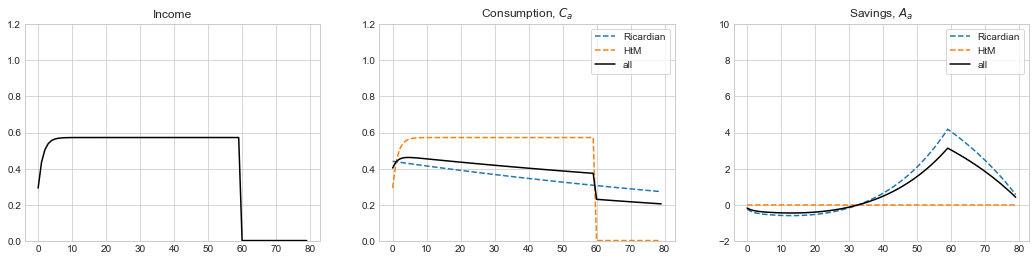

In [18]:
def plot_CA():
    
    fig = plt.figure(figsize=(3*6,1*6/1.5))

    ax = fig.add_subplot(1,3,1)
    ax.plot(ss.inc_a,label='all',color='black')
    ax.set_title('Income')
    ax.set_ylim([0,1.2])
    
    ax = fig.add_subplot(1,3,2)
    ax.plot(ss.C_R_a,ls='--',label='Ricardian')
    ax.plot(ss.C_HtM_a,ls='--',label='HtM')
    ax.plot(ss.C_a,label='all',color='black')
    ax.set_title('Consumption, $C_a$')
    ax.legend(frameon=True)
    ax.set_ylim([0,1.2])
    
    ax = fig.add_subplot(1,3,3)
    ax.plot(ss.B_R_a,ls='--',label='Ricardian')
    ax.plot(ss.B_HtM_a,ls='--',label='HtM')
    ax.plot(ss.B_a,label='all',color='black')
    ax.set_title('Savings, $A_a$')
    ax.set_ylim([-2,10])
    ax.legend(frameon=True)
    
plot_CA()

## Varying central inputs

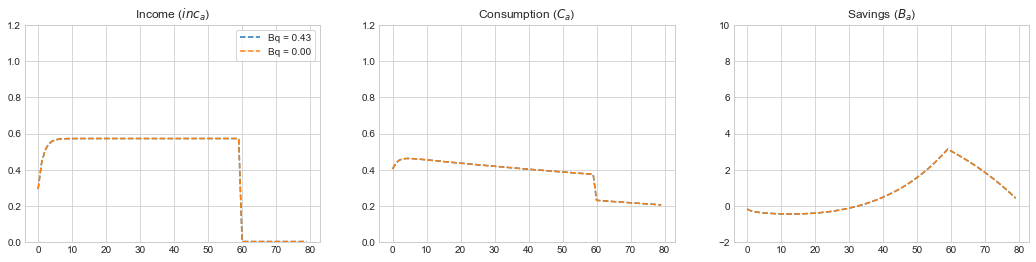

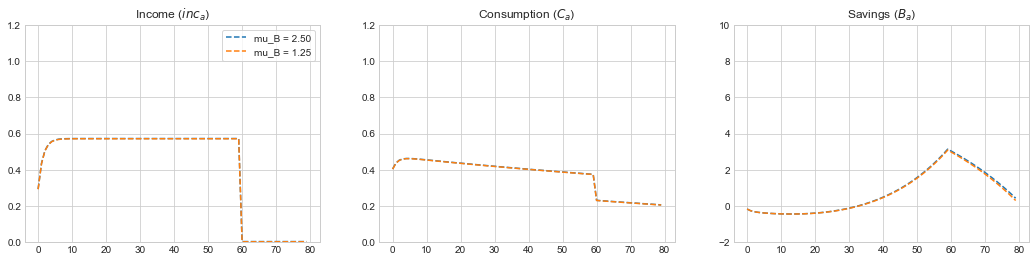

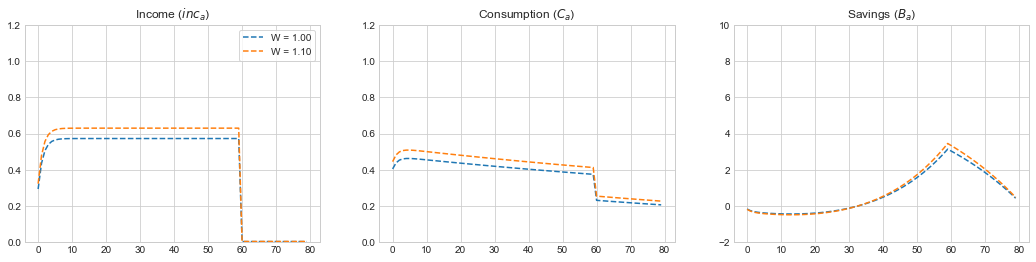

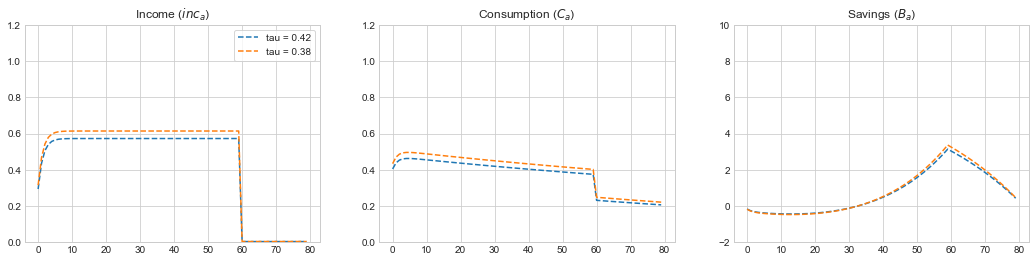

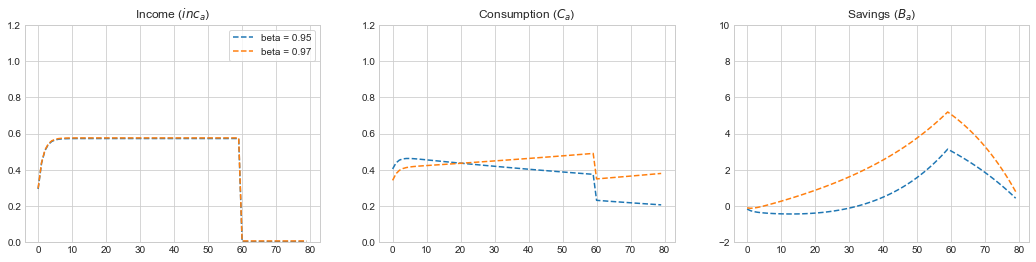

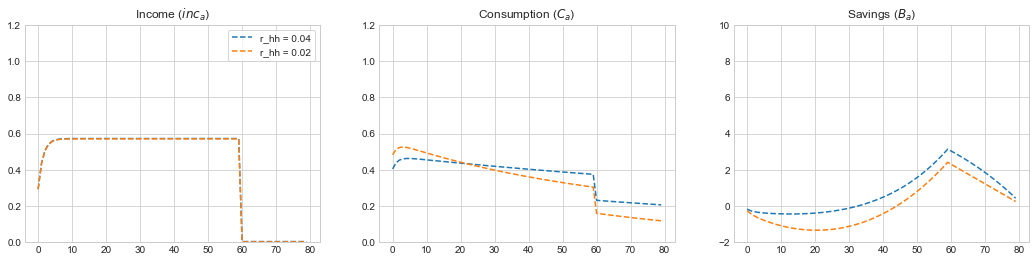

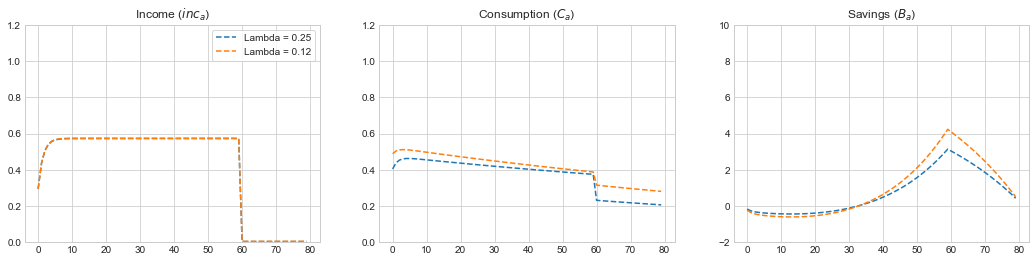

In [20]:
def compare_models(model,name,value,ns='ss'):
    model_ = model.copy()
    
    if ns == 'ss':
        model_.ss.__dict__[name] = value
        oldvalue = model.ss.__dict__[name]
    elif ns == 'par':
        model_.par.__dict__[name] = value
        oldvalue = model.par.__dict__[name]
    else:
        raise NotImplemented
            
    model_.ss.real_r_hh = (1+model_.par.r_hh)/(1+model_.ss.pi_hh)-1            
    find_household_consumption_ss(model_)

    fig = plt.figure(figsize=(3*6,1*6/1.5))

    ax = fig.add_subplot(1,3,1)
    ax.plot(ss.inc_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(model_.ss.inc_a,ls='--',label=f'{name} = {value:.2f}')
    ax.set_title('Income ($inc_{a}$)');
    ax.set_ylim([0,1.2])
    ax.legend(frameon=True)
    
    ax = fig.add_subplot(1,3,2)
    ax.plot(ss.C_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(model_.ss.C_a,ls='--',label=f'{name} = {value:.2f}')
    ax.set_title('Consumption ($C_{a}$)');
    ax.set_ylim([0,1.2])
    
    ax = fig.add_subplot(1,3,3)
    ax.plot(ss.B_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(model_.ss.B_a,ls='--',label=f'{name} = {value:.2f}')
    ax.set_title('Savings ($B_{a}$)')
    ax.set_ylim([-2,10])
    
compare_models(model,'Bq',ss.Bq*0.0)
compare_models(model,'mu_B',par.mu_B/2,ns='par')
compare_models(model,'W',ss.W*1.1)
compare_models(model,'tau',ss.tau*0.9)
compare_models(model,'beta',par.beta+0.02,ns='par')
compare_models(model,'r_hh',par.r_hh-0.02,ns='par')
compare_models(model,'Lambda',par.Lambda/2,ns='par')

# Test household blocks

In [21]:
ss.B_a[:] = ss.B_a
sol.P_C[:] = ss.P_C
sol.W[:] = ss.W
sol.tau[:] = ss.tau
sol.L[:] = ss.L
sol.m_s[:] = ss.m_s
sol.real_r_hh[:] = ss.real_r_hh

In [22]:
model.ini = ss

In [23]:
from blocks import household_search, households_consumption

In [24]:
model.evaluate_block('household_search')

In [25]:
assert np.allclose(sol.S_a-ss.S_a[:,np.newaxis],0.0)
assert np.allclose(sol.L_ubar_a-ss.L_ubar_a[:,np.newaxis],0.0)
assert np.allclose(sol.L_a-ss.L_a[:,np.newaxis],0.0)
assert np.allclose(sol.S-ss.S,0.0)
assert np.allclose(sol.L_ubar-ss.L_ubar,0.0)

In [26]:
model.evaluate_block('households_consumption')